# CNN+GRU model

Author: Liu Chang

Description: 

This notebook will demonstrate CNN+GRU hybrid model performance

Date:
Week 9

In [1]:
import os.path as path
import pickle
import torch
from torch import nn
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## Read Data

Our data has 5 calsses, overall 633244 items.

The 5 classes are:  'calendar', 'snowman', 'penguin', 'blackberry', 'teddy-bear'

In [2]:
data_path='/raid5/liuchang/quick_draw_output'
from utils.read_data import get_dataset

_,train_X,train_Y,_,test_X,test_Y=get_dataset(data_path,'1102_05b633244')

In [3]:
labels_count=len(set(test_Y))
print("The number of classes=",labels_count)
print("The number of items=",len(train_X)+len(test_X))

The number of classes= 5
The number of items= 633244


### Data Preprocessing Method 

Most of the data preprocessing jobs are done when generating our dataset.

`unpack()` is a data padding method, it is ued on minibatched data.

It pads each data item(one paint) so that the size is exactly 30x200 (which is the maximal size in our data)

In [4]:
def unpack(x,max_strock,max_len):
    x_new=torch.zeros(torch.Size([len(x),max_strock,2,max_len]))
    for i,item in enumerate(x):
        for j,strock in enumerate(item):
            strock=torch.Tensor(strock)
            x_new[i,j,0,:len(strock[0])]=strock[0]
            x_new[i,j,1,:len(strock[0])]=strock[1]
    return x_new

def get_max_len(x,xx):
    max_len=0
    max_strock=0
    for i,item in enumerate(x):
        max_strock=max(max_strock,len(item))
        for j,strock in enumerate(item):
            max_len=max(max_len,len(strock[0])) 
    for i,item in enumerate(xx):
        max_strock=max(max_strock,len(item))
        for j,strock in enumerate(item):
            max_len=max(max_len,len(strock[0])) 
    return max_strock,max_len

max_strock,max_len=get_max_len(train_X,test_X)
print("Maximal Size=",max_strock,"x",max_len)

Maximal Size= 30 x 200


Method for obtaining accuracy score

In [5]:
def get_acc(model,test_X,test_Y):
    model.eval()
    cur_len=0
    acc=0
    batch_size=4096
    while cur_len<len(test_X):
        minibatch_X=test_X[cur_len:cur_len+batch_size]
        minibatch_Index=[len(i)-1 for i in minibatch_X]
        minibatch_X=unpack(minibatch_X,max_strock,max_len).cuda()
        
        minibatch_Y=test_Y[cur_len:cur_len+batch_size]
        minibatch_Y=torch.LongTensor(minibatch_Y).cuda()
        y_predict=model(minibatch_X,minibatch_Index)
        
        y_predict=torch.argmax(y_predict,dim=1)
        cur_len+=batch_size
        acc+=(y_predict==minibatch_Y).sum().item()
    return acc/cur_len

## Model Define

Here we define our CRNN model.

### Goal
The goal of CRNN is to use a small number of parameters to achieve a good performance(accuracy) both on complete data and incomplete data.

In this model, CNN embeds each stroke. The maximal length of stroke is 200 so the CNN will not have a big parameter space

Then the RNN model uses the embedded feature of stroke to do prediction.

Also, such a structure has advantages on dealing both complete and incomplete data in one model.


### CNN

First, we define our CNN. it is a 4-layer CNN model as an embedding method, to encode one stroke with size (200,), to a vector with size (64,).

During the training process, I find that 
1. **Instead of the convolution layer which has a big reception field, the dense layer provides a better performance**
2. **The linear (dense) layer as a final layer is needed. Ending with convolution layer can not have a good performance**

In [14]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=2,      # input height
                out_channels=6,    # n_filters
                kernel_size=3      # filter size
            ),
            nn.ReLU(),    # activation
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
             nn.Conv1d(6,12, 3),
             nn.ReLU(),  # activation
             nn.MaxPool1d(kernel_size=2)
         )
        self.out1 = nn.Linear(576, 64)
        self.out2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.out1(x)
        x=F.relu(x)
        output = self.out2(x)
        return output

### CRNN
We use GRU instead of LSTM because:

1. It uses less parameters, thus less training time
2. It provides comparable performance

In [7]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.middle_size=middle_size=40
        self.gru=nn.GRU(input_size=middle_size,hidden_size=5,num_layers=3,bias=True)
        self.cnn=CNN(output_size=middle_size)
        self.out=nn.Softmax(dim=-1)
    def forward(self, x,index):
        x=x.view(-1,2,max_len)
        xx = self.cnn(x)
        xx=xx.view(-1,max_strock,self.middle_size).transpose(0,1)
        output,_ = self.gru(xx)
        to_send=output[index,range(len(index))]
        output = self.out(to_send)
        return output

Summary of the model is shown as follow.

In [18]:
model=CRNN().cuda()
print(model)
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        pp+=p.numel()
    return pp
psize=get_n_params(model)
print('Parameter size = {} ({:.2f}M)'.format(psize,psize/1e6))

CRNN(
  (gru): GRU(40, 5, num_layers=3)
  (cnn): CNN(
    (conv1): Sequential(
      (0): Conv1d(2, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(6, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (out1): Linear(in_features=576, out_features=64, bias=True)
    (out2): Linear(in_features=64, out_features=40, bias=True)
  )
  (out): Softmax()
)
Parameter size = 40863 (0.04M)


## Training model

Here we set our batch_size to be very big because each data do not have a big size (just 30x200))

We use Checkpoint to save the current best model. Also by using this method we don't have to keep this notebook open to ensure the outputs been saved.

We train our model on NVIDIA Tesla K80 with 11GB memory, training about 12 hours.

We use a large batch size because
1. It provides faster training
2. The noise is not on the pixel level but on painting level. (i.e. Most of users draw painting regard to given category while some just draw noise)
3. Each data item is rather small (just 30*200), so no need to worry about memory usage

In [ ]:
import torch.optim as optim
import pickle
import numpy as np
batch_size=1024
loss=torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
EPOCH=200

bst_acc=0.00
for i in range(EPOCH):
    total_loss=0
    cur_len=0
    total_time=0
    model.train()
    while cur_len<len(train_X):
        model.zero_grad()
        minibatch_X=train_X[cur_len:cur_len+batch_size]
        minibatch_Index=[len(i)-1 for i in minibatch_X]
        #print(len(minibatch_Index[0]))
        minibatch_X=unpack(minibatch_X,max_strock,max_len).cuda()
        
        minibatch_Y=train_Y[cur_len:cur_len+batch_size]
        minibatch_Y=torch.LongTensor(minibatch_Y).cuda()
        y_predict=model(minibatch_X,minibatch_Index)
        
        
        output_loss=loss(y_predict,minibatch_Y)
        output_loss.backward()
        optimizer.step()
        cur_len+=batch_size
        total_loss+=output_loss.item()
        total_time+=1
    if i%1==0:
        acc=get_acc(model,test_X,test_Y)
        record_file=open('record3','a')
        s="{}/{}, loss={},acc={}\n".format(i,EPOCH,np.exp(total_loss/total_time),acc)
        record_file.write(s)
        record_file.close()
        if acc>bst_acc:
            torch.save(model,"checkpoint3.pkl")
            bst_acc=acc

## Results
This training is extremely long, so we close the webpage and let it run in the backend.

The output is shown as follows.

In [36]:
import re
with open('record3','r') as f:
    x=f.read()
    print(x)
    y=re.findall(r"[-+]?[0-9]*\.?[0-9]+", x)
    loss=np.array(y[2::4]).astype(float)
    acc=np.array(y[3::4]).astype(float)

0/200, loss=3.7922473508124943,acc=0.8623913180443549
1/200, loss=3.5612389318218582,acc=0.8720545614919355
2/200, loss=3.53228335910029,acc=0.8859784526209677
3/200, loss=3.507872728400323,acc=0.8885773689516129
4/200, loss=3.497623543406412,acc=0.8977917086693549
5/200, loss=3.487760579634995,acc=0.8949171496975806
6/200, loss=3.477749062430268,acc=0.9010285408266129
7/200, loss=3.4723025478745564,acc=0.9016507056451613
8/200, loss=3.465858254679844,acc=0.908415763608871
9/200, loss=3.4627810873979845,acc=0.9082267515120968
10/200, loss=3.4576102234428108,acc=0.9058010962701613
11/200, loss=3.456447895893571,acc=0.907013923891129
12/200, loss=3.452568750854598,acc=0.9066280241935484
13/200, loss=3.4551392452991188,acc=0.9150154359879032
14/200, loss=3.4500280207632827,acc=0.9146452872983871
15/200, loss=3.448011085730976,acc=0.9132040700604839
16/200, loss=3.4468636462381594,acc=0.9137632308467742
17/200, loss=3.4477444641675863,acc=0.9153698336693549
18/200, loss=3.4441285466479905,

Then we visualize the training process by showing the loss changes and accuracy changes on test dataset

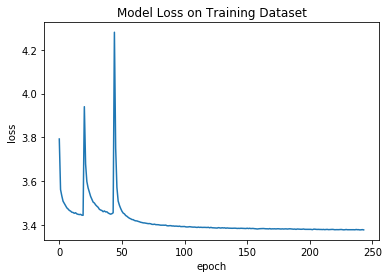

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss)
plt.title('Model Loss on Training Dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

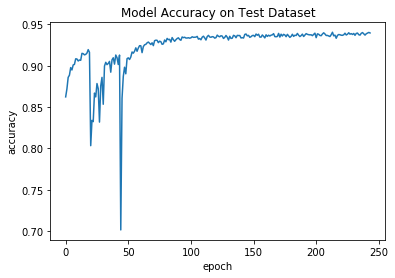

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(acc)
plt.title('Model Accuracy on Test Dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### Performance on incomplete data
The accuracy on incomplete data is shown as follows.

The incomplete data is the same painting with complete data, but we keep only the first 50%,70%,90% of the data.

In [20]:
ratio_to_test=[0.5,0.7,0.9,1]
def incomplete_test(model,r):
    _,_,_,_,test_X,testY=get_dataset(dataset_name='1102_05b633244',test_r=r)
    acc=get_acc(model,test_X,testY)
    print("{},{}".format(r,acc))
model_name='checkpoint3.pkl'
model=torch.load(model_name).cuda()
for r in ratio_to_test:
    incomplete_test(model,r)

0.5,0.7955755418346774
0.7,0.8623283140120968
0.9,0.9028241557459677
1,0.9405556955645161
